In [1]:
import sys
sys.path.append('./helpers')
sys.path.append('./optimizers')

In [2]:
# External libraries
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import networkx as nx
from deap import gp

# Custom functions and classes
from pymoo_optimizer import PymooOptimizer
import benchmark as Benchmark
import data_provider as dp
import feature_evolver as fe

## Introduction
In data science, often a question of "How can we make this prediction better?" is asked, an the ultimate answer for it is to have either more data, or better data. There's a reason why GIGO (Garbage In, Garbage Out) principle is so commonly known - one can't describe any phenomena any better than the sheer data describes it. 
<br>
There is, however, an approach that might be somehow counter-intuitive, but might yield interesting results, and that is feature engineering in forms of both feature selection and feature creation.

#### Feature selection
It comes as no surprise that sometimes dataset provided from data source is not equally relevant across its features. While today's humidity and 
temperature might be important for tomorrow's weather, whether it's going to be Saturday or Wednesday is not meaningful at all. That is why certain columns may be simply dropped from the dataset before attempting to properly model it. There's one, quite obvious, benefit to it, which is decreasing the size of the input data, meaning faster model training. There's no doubt, and the tests within project actually proved it, that there is much time to be saved by dropping irrelevant columns, it might however be somehow interesting that within tested data - which is to be shown later - on-average classification accuracy was better almost every time, than when raw data has been used. That might be due to the fact that less-relevant features may distract the algorithm which will try to utilize it the best way possible, assuming it may hold important information. One could consider irreleveant columns to be a noise, that does not provide any important knowledge, but instead draws attention from more meaningful columns. After feature selection, once only important data is available, the training process is only exposed to relevant information, using it to full potential.
<br>

#### Feature creation
As a next step and more nuclear approach, we attempted to create new synthetic datasets from scratch, based on dataset provided to an algorithm. Each column is a number that is nothing more than just a result of more or less sophisticated equation that takes dataset features as variables. That, of course, shows the first weakness of such approach, meaning only numerical data is valid for such solution. Dataset is created with respect to given boundaries of minimal of maximal amount of new columns, and features are created as long as they provide improvement to prediction results - meaning that after N failed attempts to add another column, algorithm terminates. Comparing to previous method, it tends to achieve even further data compression (due to the fact it combines relevant columns, not only chooses them). Regarding Breast dataset from UCI repository, it almost never ended up having more than two columns - from initial 30. That's over 90% size reduction, which is already impressive, considering that results achieved with such data have been very encouraging.

<br>
<br>
Let's check different datasets of various difficulty and see if, and if so, how much of an improvement can be achieved via mentioned methods.
Before proceeding, it has to be said that each of results is shown as a mean score of 5 runs of an algorithm, meaning results are much more robust to outliers than single-run prediction score.

In [ ]:
from evolutionary_forest.forest import EvolutionaryForestRegressor
from sklearn.metrics import r2_score
MAX_PROCESSES = 1

dataset_name = ['students', 'energy', 'concrete', 'maintenance', 'forest_fires', 'churn', 'wine_qual']

r2_before = []
r2_selection = []
r2_creation = []
evo_forest = []

for dataset in dataset_name:
    success = False
    while not success:
        try:
            x_train, x_test, x_val, y_train, y_test, y_val = dp.get_train_test_validation_data(dataset, 0.8, 0.1)
            x_train.columns = x_train.columns.str.replace(' ', '_')
            x_test.columns = x_test.columns.str.replace(' ', '_')
            x_val.columns = x_val.columns.str.replace(' ', '_')

            optimizer = PymooOptimizer(x_train, x_val, y_train, y_val)
            solution, score = optimizer.optimize(64, 100, Benchmark.regressor_r2_score, verbose = False, repeats=5)

            raw_score = np.round(Benchmark.regressor_r2_score(x_train, x_test, y_train, y_test, 5), 4)
            optimized_score = np.round(Benchmark.regressor_r2_score(x_train.loc[:, solution], x_test.loc[:, solution], y_train, y_test, 5), 4)

            optimizer_constructor = lambda x_train, x_val, y_train, y_val: PymooOptimizer(x_train, x_val, y_train, y_val)
            x_train_2, x_test_2, x_val_2 = fe.evolve_new_feature_set(optimizer_constructor, x_train, x_val, y_train, y_val, x_test, verbose=False,
                                                                    heuristics=Benchmark.regressor_r2_score, epochs=50, population_size=64, repeats=5,
                                                                    min_features=2, max_features=20)

            new_score= np.round(Benchmark.regressor_r2_score(x_train_2, x_test_2, y_train, y_val, 5), 4)

            r = EvolutionaryForestRegressor(max_height=3, normalize=True, select='AutomaticLexicase',
                                        gene_num=10, boost_size=100, n_gen=50, n_pop=64, cross_pb=1,
                                        base_learner='Random-DT', verbose=False, n_process=MAX_PROCESSES)
            r.fit(x_train, y_train)
            evo_forest_score = np.round(r2_score(y_test, r.predict(x_test)), 4)

            r2_before.append(raw_score)
            r2_selection.append(optimized_score)
            r2_creation.append(new_score)
            evo_forest.append(evo_forest_score)

            print(f'Dataset: {dataset}\n'+
                  f'R2 before: {raw_score}\n'+
                 f'R2 selection: {optimized_score}\n'+
                 f'R2 creation: {new_score}\n'+
                  f'R2 evo forest: {evo_forest_score}\n\n')
            success = True
        except Exception as e:
            print(f"Error {e}, retrying...\n\n")

### Regression problems
7 different regression datasets have been selected (IDs of 162, 320, 165, 601, 89, 563, 374 from UCI Repository) for regression task that shall be measured with R2 score of Decision Tree Regressor algorithm. Along aforementioned methods, Evolutionary Forest, a state-of-the-art solution for discussed problem, has been tested.
<br>
<br>
What plainly can be seen that there's barely any disandvantage to using any of dataset transformation methods. There's only one scenario - churn dataset - where raw dataset's score achieved slightly better results than result of feature selection, although the difference is so small that for such problem statistical significance should be measured. Apart from that, there's one dataset where every method achieved same result, being equal or very close to 1.0 R2. The reason for that might be simplicity of regression problem in selected dataset. In all other scenarios, feature selection has proven to be better than training on raw dataset, and feature creation has been even more effective, not to say efficient - as what this chart does not say, is that in both of those cases data was significanlty compressed, and the training was faster.
<br>
<br>
What's worth taking a look at is that while Evolutionary Forest indeed outclassed all of previous methods, it was outperformed by feature creation method within datasets of Students and Forest Fires, although it has to be said that Forest Fires result is still not satisfactory, having achieved only little above 0.2 R2. Also, regarding Students dataset, result difference between three dataset transformation methods was rather little.

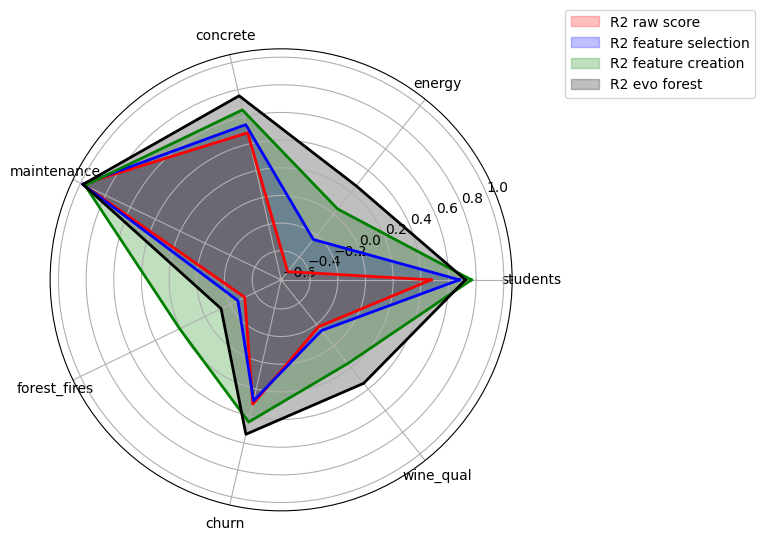

In [4]:
# Number of variables
num_vars = len(dataset_name)

# Compute the angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by appending the start to the end
r2_before += [r2_before[0]]
r2_selection += [r2_selection[0]]
r2_creation += [r2_creation[0]]
evo_forest += [evo_forest[0]]
angles += [angles[0]]

# Initialize the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Draw each list
ax.fill(angles, r2_before, color='red', alpha=0.25, label='R2 raw score')
ax.plot(angles, r2_before, color='red', linewidth=2, linestyle='solid')

ax.fill(angles, r2_selection, color='blue', alpha=0.25, label='R2 feature selection')
ax.plot(angles, r2_selection, color='blue', linewidth=2, linestyle='solid')

ax.fill(angles, r2_creation, color='green', alpha=0.25, label='R2 feature creation')
ax.plot(angles, r2_creation, color='green', linewidth=2, linestyle='solid')

ax.fill(angles, evo_forest, color='black', alpha=0.25, label='R2 evo forest')
ax.plot(angles, evo_forest, color='black', linewidth=2, linestyle='solid')

# Add labels to each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dataset_name)

ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))

plt.show()

In [ ]:
import time
dataset_name = ['cirrhosis', 'breast', 'rice', 'bank_marketing', 'aids', 'national_poll']
heuristics_repeats = 5

accuracy_before = []
accuracy_selection = []
accuracy_creation = []

for dataset in dataset_name:
    start = time.time()
    success = False
    while not success:
        try:
            x_train, x_test, x_val, y_train, y_test, y_val = dp.get_train_test_validation_data(dataset, 0.8, 0.1)
            x_train.columns = x_train.columns.str.replace(' ', '_')
            x_test.columns = x_test.columns.str.replace(' ', '_')
            x_val.columns = x_val.columns.str.replace(' ', '_')

            optimizer = PymooOptimizer(x_train, x_val, y_train, y_val)
            solution, score = optimizer.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False, repeats=5)

            raw_score = np.round(Benchmark.dtree_accuracy(x_train, x_test, y_train, y_test, heuristics_repeats) * 100, 2)

            x_train_2, x_val_2, x_test_2 = fe.evolve_new_feature(optimizer, x_test, verbose=False, repeats=heuristics_repeats, name='new_feature')

            score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2, x_test_2, y_train, y_test, heuristics_repeats) * 100, 2)

            optimizer_2 = PymooOptimizer(x_train_2, x_val_2, y_train, y_val)
            solution, score = optimizer_2.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False, repeats=heuristics_repeats)

            optimized_score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2.loc[:, solution], x_test_2.loc[:, solution], y_train, y_test, heuristics_repeats) * 100, 2)

            
            accuracy_before.append(raw_score)
            accuracy_selection.append(optimized_score_with_new_feature)
            accuracy_creation.append(score_with_new_feature)

            print(f'Dataset: {dataset}\n'+
                  f'Accuracy before: {raw_score}\n'+
                 f'Accuracy creation: {score_with_new_feature}\n'+
                 f'Accuracy creation and selection: {optimized_score_with_new_feature}\n\n')
            success = True
        except Exception as e:
            print(f"Error {e}, retrying...\n\n")
    end = time.time()
    print(f"Time taken: {(end-start)*10**3:.03f}ms")

### Classification problems
Similar test has been taken over six classification-oriented datasets (UCI IDs: 936, 890, 878, 545, 17, 222). For classification task, accuracy metric has been chosen along Decision Tree Classifier algorithm.
<br>
<br>
The rule of thumb found during regression study is still valid - transformed data always performs better, or very similarily, to raw data. What might, however, be a little surprising, is the fact that, except Cirrhosis dataset, Feature Selecetion technique serves classification better than feature creation.
<br>
It's not obvious what is the reason for differences between approaches being less visible than in regression analysis. It might be the nature of the problem, or the way Decision Tree works, so that they're more robust to irrelevant data. It might be that, if exposed to multi-class classification problem, the results would be rather different, perhaps highlighting data transformation advantages more than binary classification. That remains an interesting subject that could be explored further as an extension of this research.

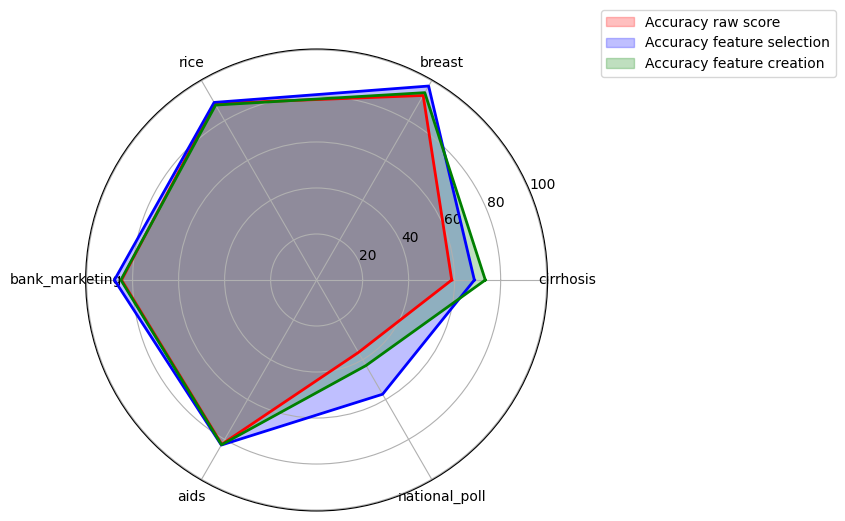

In [7]:
# Number of variables
num_vars = len(dataset_name)

# Compute the angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by appending the start to the end
accuracy_before += [accuracy_before[0]]
accuracy_selection += [accuracy_selection[0]]
accuracy_creation += [accuracy_creation[0]]
angles += [angles[0]]

# Initialize the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})

# Draw each list
ax.fill(angles, accuracy_before, color='red', alpha=0.25, label='Accuracy raw score')
ax.plot(angles, accuracy_before, color='red', linewidth=2, linestyle='solid')

ax.fill(angles, accuracy_selection, color='blue', alpha=0.25, label='Accuracy feature selection')
ax.plot(angles, accuracy_selection, color='blue', linewidth=2, linestyle='solid')

ax.fill(angles, accuracy_creation, color='green', alpha=0.25, label='Accuracy feature creation')
ax.plot(angles, accuracy_creation, color='green', linewidth=2, linestyle='solid')

# Add labels to each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dataset_name)

ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1.1))

plt.show()

### Summary
Wrapping all of above, it is definite that data transformation does help performing both binary classification and regression tasks, reducing, sometimes to a very significant point, model's training time, data size, and also, in most cases, performance of the model. Having said that, there's still much to explore and investigate regarding data transformation methods, including different kinds of problems like multi-class classification, or different algortihms for already examined classes of problems.